<a href="https://colab.research.google.com/github/Basakrana/ASD-PREDICTION-MODEL/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
!python --version

Python 3.11.13


In [ ]:
df = pd.read_csv("/content/train.csv")

In [ ]:
df.shape

(800, 22)

In [ ]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [ ]:
df.sample().T

,456
ID,457
A1_Score,1
A2_Score,1
A3_Score,0
A4_Score,1
A5_Score,0
A6_Score,0
A7_Score,1
A8_Score,0
A9_Score,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [ ]:
# Cleaning
df = df.drop(columns=["ID", "age_desc"])
df["age"] = df["age"].astype(int)

In [ ]:
for col in df.columns:
  numerical_features = ["age", "result"]
  if col not in numerical_features:
    print(col, df[col].unique())
    print("-"*50)

A1_Score [1 0]
--------------------------------------------------
A2_Score [0 1]
--------------------------------------------------
A3_Score [1 0]
--------------------------------------------------
A4_Score [0 1]
--------------------------------------------------
A5_Score [1 0]
--------------------------------------------------
A6_Score [0 1]
--------------------------------------------------
A7_Score [1 0]
--------------------------------------------------
A8_Score [0 1]
--------------------------------------------------
A9_Score [1 0]
--------------------------------------------------
A10_Score [1 0]
--------------------------------------------------
gender ['f' 'm']
--------------------------------------------------
ethnicity ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
--------------------------------------------------
jaundice ['no' 'yes']
--------------------------------------------------
austim

In [ ]:
mapping = {
    "Viet Nam": "Vietnam",
    "AmericanSamoa": "United States",
    "Hong Kong": "China"
}
df["contry_of_res"] = df["contry_of_res"].replace(mapping)

In [ ]:

# Fix ethnicity and relation
df["ethnicity"] = df["ethnicity"].replace({"?": "Others", "others": "Others"})
df["relation"] = df["relation"].replace(
    {"?": "Others", "Relative": "Others", "Parent": "Others", "Health care professional": "Others"}
)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
A1_Score,800.0,0.560000,0.496697,0.000000,0.000000,1.000000,1.000000,1.000000
A2_Score,800.0,0.530000,0.499411,0.000000,0.000000,1.000000,1.000000,1.000000
A3_Score,800.0,0.450000,0.497805,0.000000,0.000000,0.000000,1.000000,1.000000
A4_Score,800.0,0.415000,0.493030,0.000000,0.000000,0.000000,1.000000,1.000000
A5_Score,800.0,0.395000,0.489157,0.000000,0.000000,0.000000,1.000000,1.000000
A6_Score,800.0,0.303750,0.460164,0.000000,0.000000,0.000000,1.000000,1.000000
A7_Score,800.0,0.397500,0.489687,0.000000,0.000000,0.000000,1.000000,1.000000
A8_Score,800.0,0.508750,0.500236,0.000000,0.000000,1.000000,1.000000,1.000000
A9_Score,800.0,0.495000,0.500288,0.000000,0.000000,0.000000,1.000000,1.000000
A10_Score,800.0,0.617500,0.486302,0.000000,0.000000,1.000000,1.000000,1.000000


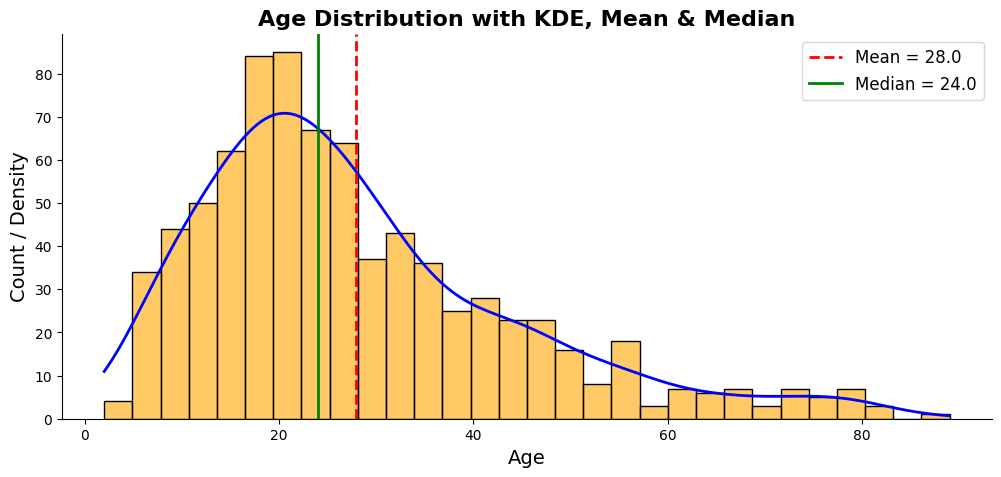

In [ ]:
plt.figure(figsize=(12,5))

# histogram + KDE together
sns.histplot(
    df["age"],
    bins=30,
    kde=True,
    color="orange",         # histogram color
    edgecolor="black",
    alpha=0.6
)

# recolor the KDE line (last line plotted by histplot)
plt.gca().lines[-1].set_color("blue")
plt.gca().lines[-1].set_linewidth(2)

# calculate mean and median
age_mean = df["age"].mean()
age_median = df["age"].median()

# vertical lines
plt.axvline(age_mean, color="red", linestyle="--", linewidth=2, label=f"Mean = {age_mean:.1f}")
plt.axvline(age_median, color="green", linestyle="-", linewidth=2, label=f"Median = {age_median:.1f}")

# formatting
plt.title("Age Distribution with KDE, Mean & Median", fontsize=16, fontweight="bold")
plt.xlabel("Age", fontsize=14)
plt.ylabel("Count / Density", fontsize=14)
plt.legend(fontsize=12)
sns.despine()
plt.show()


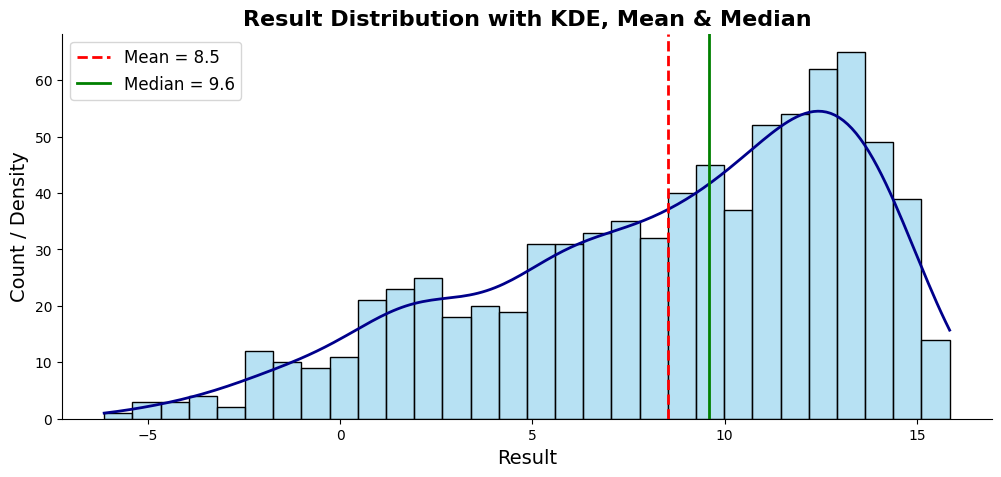

In [ ]:
plt.figure(figsize=(12,5))

# histogram + KDE together
sns.histplot(
    df["result"],
    bins=30,
    kde=True,
    color="skyblue",         # histogram color
    edgecolor="black",
    alpha=0.6
)

# recolor the KDE line (last line plotted by histplot)
plt.gca().lines[-1].set_color("darkblue")
plt.gca().lines[-1].set_linewidth(2)

# calculate mean and median
result_mean = df["result"].mean()
result_median = df["result"].median()

# vertical lines
plt.axvline(result_mean, color="red", linestyle="--", linewidth=2, label=f"Mean = {result_mean:.1f}")
plt.axvline(result_median, color="green", linestyle="-", linewidth=2, label=f"Median = {result_median:.1f}")

# formatting
plt.title("Result Distribution with KDE, Mean & Median", fontsize=16, fontweight="bold")
plt.xlabel("Result", fontsize=14)
plt.ylabel("Count / Density", fontsize=14)
plt.legend(fontsize=12)
sns.despine()
plt.show()


In [ ]:
# Replace outliers with median
def replace_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = df[column].median()
    df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
    return df

df = replace_outliers_with_median(df, "age")
df = replace_outliers_with_median(df, "result")

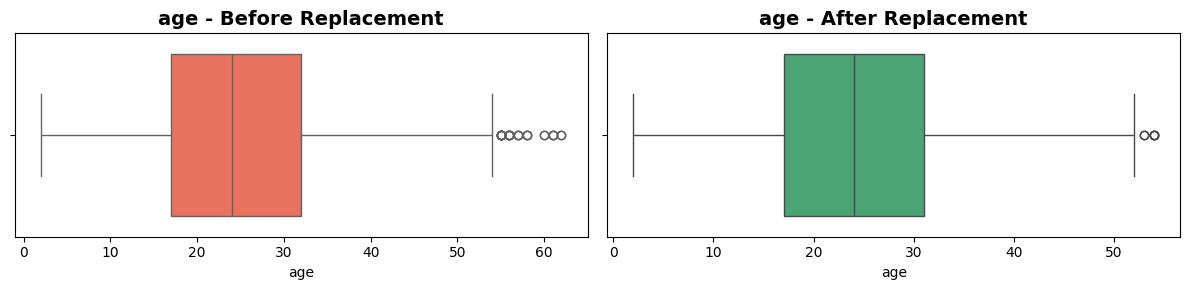

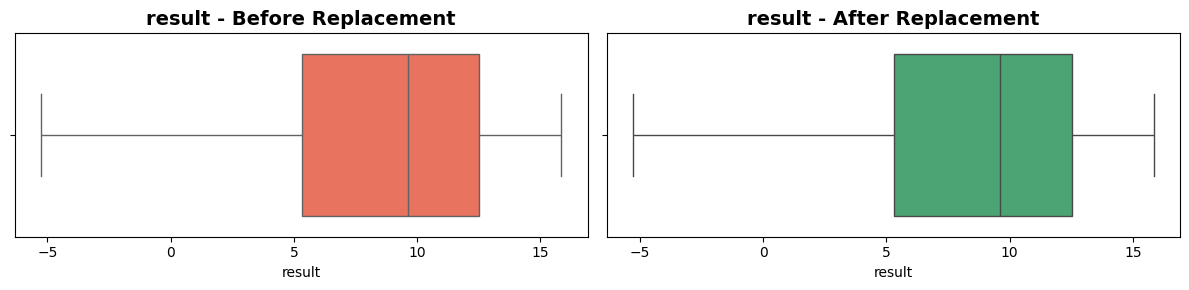

In [ ]:
# Keep original data before replacing
df_original = df.copy()

# Replace outliers
df_cleaned = replace_outliers_with_median(df.copy(), "age")
df_cleaned = replace_outliers_with_median(df_cleaned, "result")

# Visualization function
def visualize_outlier_replacement(original_df, cleaned_df, column):
    plt.figure(figsize=(12,3))

    # Before replacement
    plt.subplot(1, 2, 1)
    sns.boxplot(x=original_df[column], color="tomato")
    plt.title(f"{column} - Before Replacement", fontsize=14, fontweight="bold")

    # After replacement
    plt.subplot(1, 2, 2)
    sns.boxplot(x=cleaned_df[column], color="mediumseagreen")
    plt.title(f"{column} - After Replacement", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

# Show for "age"
visualize_outlier_replacement(df_original, df_cleaned, "age")

# Show for "result"
visualize_outlier_replacement(df_original, df_cleaned, "result")


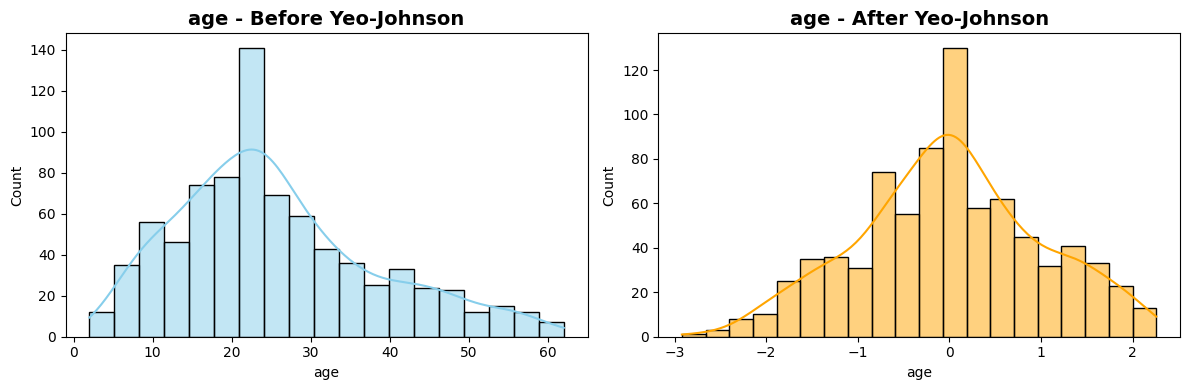

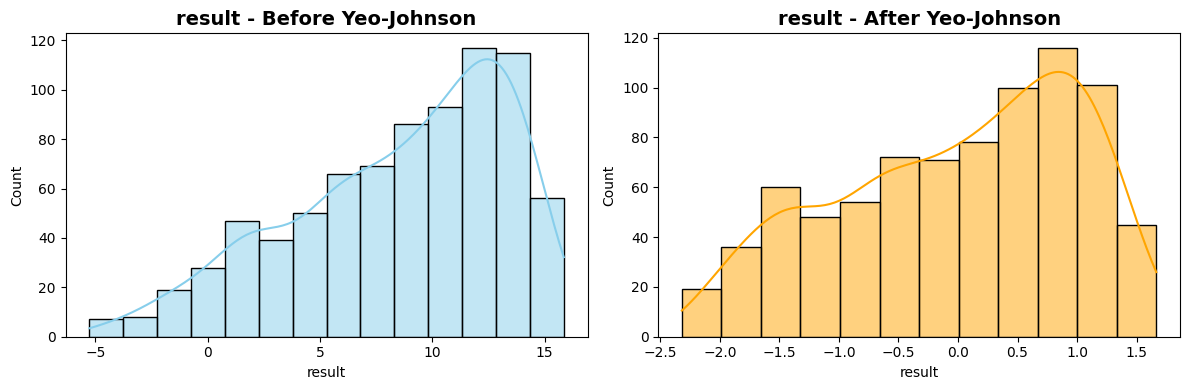

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Make a copy of data
df_transformed = df.copy()

# Apply Yeo-Johnson Transformation
pt = PowerTransformer(method='yeo-johnson')
df_transformed[["age", "result"]] = pt.fit_transform(df[["age", "result"]])

# Visualization function
def visualize_yeojohnson(original_df, transformed_df, column):
    plt.figure(figsize=(12,4))

    # Before transformation
    plt.subplot(1, 2, 1)
    sns.histplot(original_df[column], kde=True, color="skyblue")
    plt.title(f"{column} - Before Yeo-Johnson", fontsize=14, fontweight="bold")

    # After transformation
    plt.subplot(1, 2, 2)
    sns.histplot(transformed_df[column], kde=True, color="orange")
    plt.title(f"{column} - After Yeo-Johnson", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

# Show for "age"
visualize_yeojohnson(df, df_transformed, "age")

# Show for "result"
visualize_yeojohnson(df, df_transformed, "result")


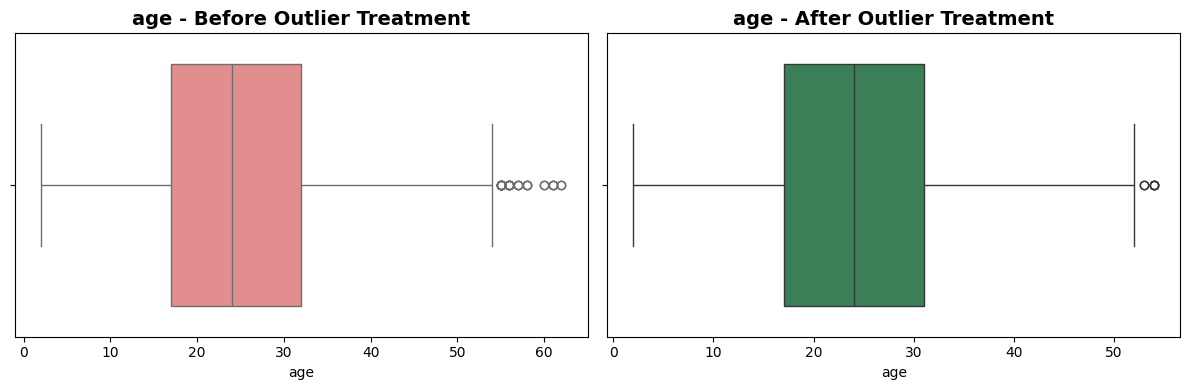

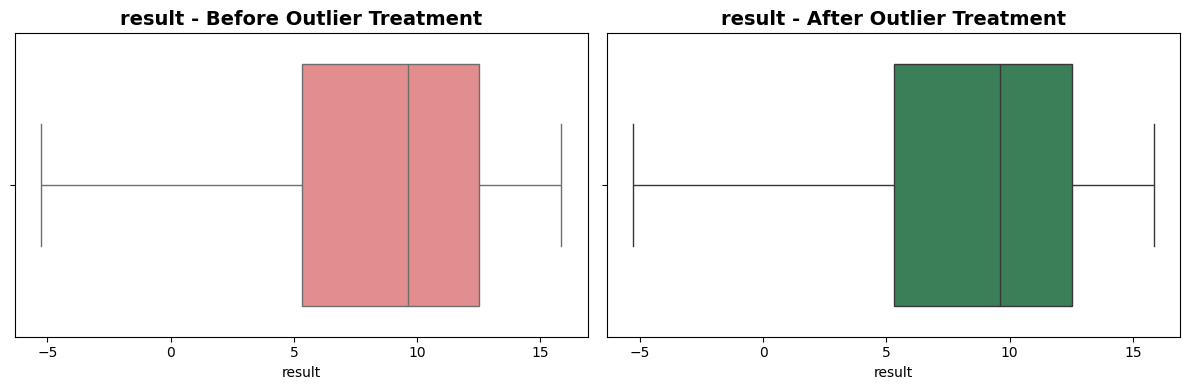

In [ ]:
# Visualization function for outlier treatment
def visualize_outlier_treatment(original_df, treated_df, column):
    plt.figure(figsize=(12,4))

    # Before
    plt.subplot(1, 2, 1)
    sns.boxplot(x=original_df[column], color="lightcoral")
    plt.title(f"{column} - Before Outlier Treatment", fontsize=14, fontweight="bold")

    # After
    plt.subplot(1, 2, 2)
    sns.boxplot(x=treated_df[column], color="seagreen")
    plt.title(f"{column} - After Outlier Treatment", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()


# Keep a copy of original data (before replacing outliers)
df_original = df.copy()

# Apply outlier treatment again for visualization
df_treated = df_original.copy()
df_treated = replace_outliers_with_median(df_treated, "age")
df_treated = replace_outliers_with_median(df_treated, "result")

# Visualize "age"
visualize_outlier_treatment(df_original, df_treated, "age")

# Visualize "result"
visualize_outlier_treatment(df_original, df_treated, "result")


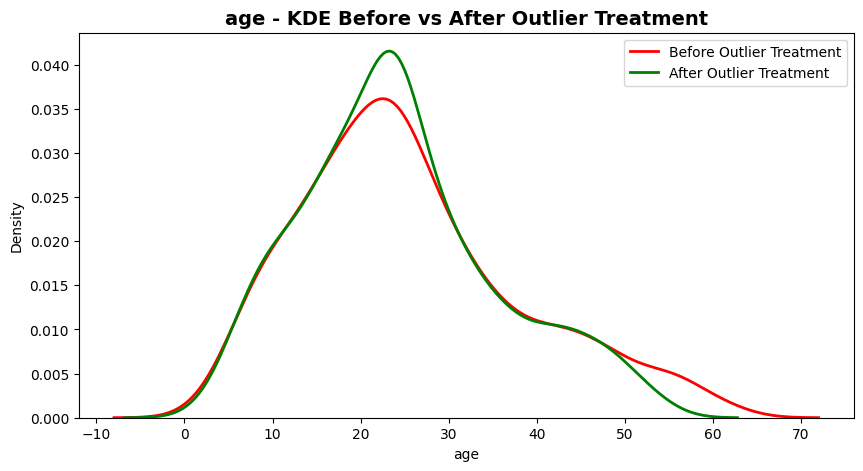

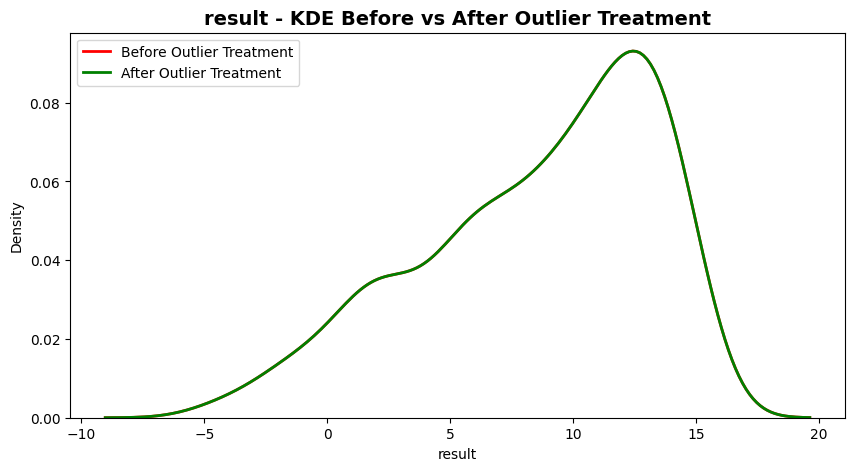

In [ ]:
# KDE plot comparison before vs after outlier treatment
def visualize_kde_outlier_treatment(original_df, treated_df, column):
    plt.figure(figsize=(10,5))

    # Plot original
    sns.kdeplot(original_df[column], label="Before Outlier Treatment", color="red", linewidth=2)

    # Plot after treatment
    sns.kdeplot(treated_df[column], label="After Outlier Treatment", color="green", linewidth=2)

    plt.title(f"{column} - KDE Before vs After Outlier Treatment", fontsize=14, fontweight="bold")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


# Make copies
df_original = df.copy()
df_treated = df_original.copy()

# Apply outlier replacement
df_treated = replace_outliers_with_median(df_treated, "age")
df_treated = replace_outliers_with_median(df_treated, "result")

# KDE plots
visualize_kde_outlier_treatment(df_original, df_treated, "age")
visualize_kde_outlier_treatment(df_original, df_treated, "result")


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
n_cols = 3
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(data=df, x=col, palette="Set2", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel("")  # remove redundant label
    axes[i].set_ylabel("Count")

    # Rotate x labels if too many categories
    axes[i].tick_params(axis="x", rotation=45)

    # Add count labels on top of bars
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}",
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha="center", va="bottom", fontsize=10, color="black")

# Hide extra axes if any
for j in range(len(categorical_columns), len(axes)):
    axes[j].set_visible(False)

sns.despine()
plt.tight_layout()
plt.show()


NameError: name 'categorical_columns' is not defined

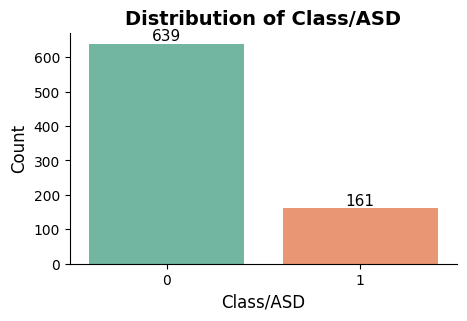

In [ ]:
plt.figure(figsize=(5,3))
ax = sns.countplot(x="Class/ASD", data=df, palette="Set2")

# Title & labels
plt.title("Distribution of Class/ASD", fontsize=14, fontweight="bold")
plt.xlabel("Class/ASD", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha="center", va="bottom", fontsize=11, color="black")

sns.despine()
plt.show()


In [ ]:
X = df.drop(columns=["Class/ASD"])
y = df["Class/ASD"]

categorical_columns = X.select_dtypes(include=["object"]).columns.tolist()
numerical_columns = ["age", "result"]


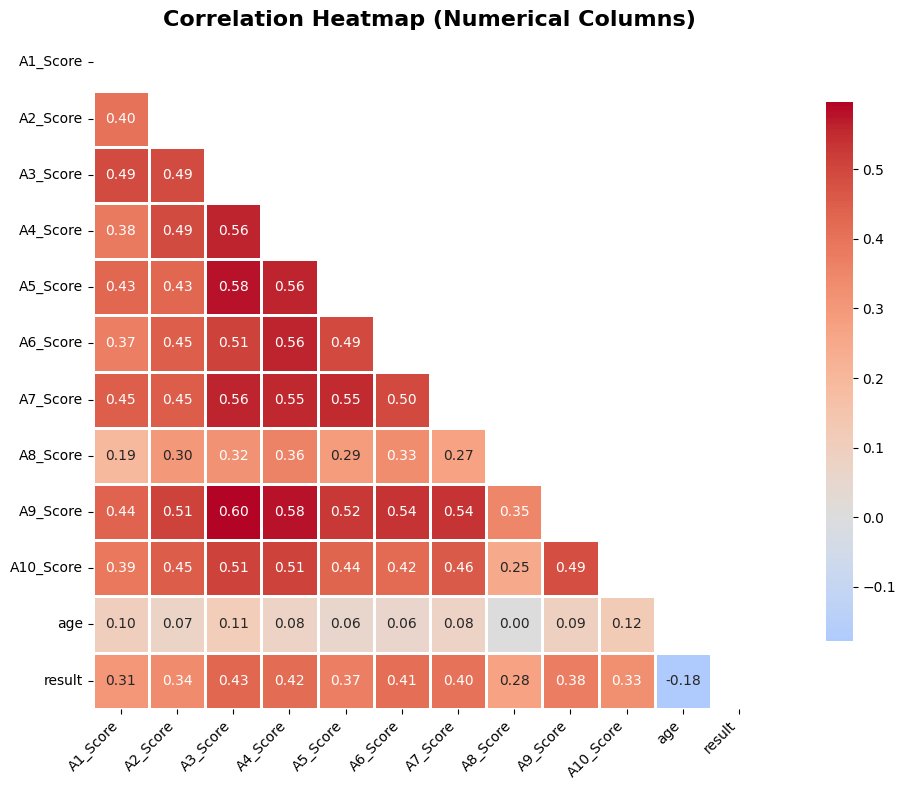

In [ ]:
numerical_df = X.select_dtypes(include=np.number)
corr = numerical_df.corr()

plt.figure(figsize=(12, 8))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.8,
    linecolor='white',
    cbar_kws={"shrink": 0.8},
    mask=mask,
    square=True,
    annot_kws={"size":10}
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Correlation Heatmap (Numerical Columns)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


      feature       VIF
0    A1_Score  3.346622
1    A2_Score  3.453457
2    A3_Score  3.966538
3    A4_Score  3.637458
4    A5_Score  3.143368
5    A6_Score  2.549044
6    A7_Score  3.171554
7    A8_Score  2.438231
8    A9_Score  4.129110
9   A10_Score  4.173549
10        age  2.824559
11     result  4.085335


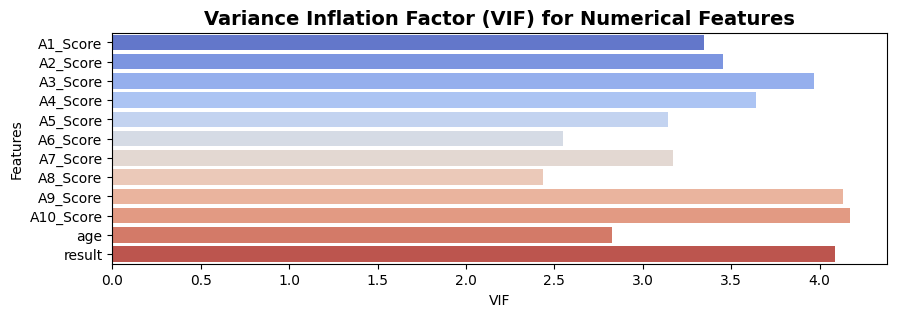

In [ ]:

# Make a copy of the original dataset

# Select numerical columns from the copied dataset
ndf = X.select_dtypes(include=np.number)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = ndf.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i)
                   for i in range(ndf.shape[1])]

# Display VIF values
print(vif_data)

# Optional: Visualize VIF
plt.figure(figsize=(10,3))
sns.barplot(x="VIF", y="feature", data=vif_data, palette="coolwarm")
plt.title("Variance Inflation Factor (VIF) for Numerical Features", fontsize=14, fontweight="bold")
plt.xlabel("VIF")
plt.ylabel("Features")
plt.show()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_columns),
        ('num', PowerTransformer(method='yeo-johnson'), numerical_columns)
    ]
)

In [ ]:
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}


In [ ]:
random_search_rf = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['gender',
                                                                                'ethnicity',
                                                                                'jaundice',
                                                                                'austim',
                                                                                'contry_of_res',
                                                                                'used_app_before',
                                                                                'relation']),
                                                                              ('num',
                                                                               PowerTransformer(),
                                                                               ['age',
                                                                                'result'])])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [None, 10, 20,
                                                                  30],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200,
                                                                     500]},
                   random_state=42, scoring='accuracy')

In [ ]:
best_model = random_search_rf.best_estimator_

In [ ]:
y_test_pred = best_model.predict(X_test)

In [ ]:
print("Best Parameters:", random_search_rf.best_params_)
print("Accuracy score:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Best Parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 30, 'classifier__bootstrap': False}
Accuracy score: 0.81875
Confusion Matrix:
 [[113  15]
 [ 14  18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.89       128
           1       0.55      0.56      0.55        32

    accuracy                           0.82       160
   macro avg       0.72      0.72      0.72       160
weighted avg       0.82      0.82      0.82       160



In [ ]:
from sklearn.model_selection import cross_val_score

# cross-validation on the final best model
cv_scores = cross_val_score(
    best_model, X, y,
    cv=10,
    scoring="accuracy",
    n_jobs=-1
)

print("Cross-validation accuracies:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))
print("Std Dev:", np.std(cv_scores))

Cross-validation accuracies: [0.8875 0.725  0.8    0.9375 0.8875 0.8    0.875  0.8125 0.85   0.8   ]
Mean CV Accuracy: 0.8375
Std Dev: 0.05836308764964374


In [ ]:
import joblib

# Save the trained pipeline
joblib.dump(best_model, "random_forest_pipeline.pkl", protocol=4)
print("Pipeline saved successfully!")

Pipeline saved successfully!
